# Why stock market volatility benefits the wealthy

In [90]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import init_objects
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments, confidence_interval
from functions.inequality import gini
from model import *
import statsmodels.api as sm
from matplotlib import style
from functions.evolutionaryalgo import *
import scipy.stats as stats
from SALib.sample import latin
import statsmodels.api as sm
import scipy.stats
from statsmodels.iolib.summary2 import summary_col

In [2]:
style.use('seaborn-ticks')

In [3]:
params = {
    "ticks": 600, # lenght of Campbell et al. 2019 data      
    "n_traders": 20, # selected for comp efficiency
    "init_stocks": 81, # Campbell et al. 2019 total stocks / n-agents 
    "init_price": 1101.111,#S&P 500 price
    "white_noise": 0.05,
         }

## Estimate params to replicate inequality increase?

What are the moments to replicate?

Params to estimate is stdev noise? 

## Run model

In [4]:
NRUNS = 5

In [5]:
trdrs = []
orbs = []
for seed in range(NRUNS):
    traders, orderbook = init_objects.init_objects_model(params, seed)
    traders, orderbook = volatility_inequality_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4


### Calculate agent wealth & log returns 

In [6]:
portfolios = {}
long_list_portfolios = {'wealth': [], 'log_wealth': [], 'returns': [], 'log_returns':[], 'period':[], 'agent_id': []}

for seed in range(NRUNS):
    for p_idx, portf in enumerate(trdrs[seed]):
        value_over_time = []
        log_value_over_time = []
        returns_over_time = []
        log_returns_over_time = []
        periods = []
        agent = []
        
        for t in range(params["ticks"] - 1):
            v0 = portf.var.wealth[t]
            value_over_time.append(v0)
            log_value_over_time.append(np.log(v0))
            
            v1 = portf.var.wealth[t+1]
            returns_over_time.append(((v1 - v0) / v0))
            log_returns_over_time.append(np.log(v1/v0))
            
            periods.append(t)
            agent.append(str(p_idx) + '_' + str(seed))

        portfolios['value_{}_seed_{}'.format(p_idx, seed)] = value_over_time
        portfolios['log_value_{}_seed_{}'.format(p_idx, seed)] = log_value_over_time
        portfolios['return+1_{}_seed_{}'.format(p_idx, seed)] = returns_over_time
        portfolios['log_return+1_{}_seed_{}'.format(p_idx, seed)] = log_returns_over_time
        
        
        long_list_portfolios['period'] += periods
        long_list_portfolios['agent_id'] += agent#str(seed) + '_' + str(agent)
        
        long_list_portfolios['wealth'] += value_over_time
        long_list_portfolios['log_wealth'] += log_value_over_time
        long_list_portfolios['returns'] += returns_over_time
        long_list_portfolios['log_returns'] += log_returns_over_time

## 1 Do simple returns correlate with wealth?

In [7]:
wealth_returns = pd.DataFrame(long_list_portfolios)
wealth_returns.head(5)

,wealth,log_wealth,returns,log_returns,period,agent_id
0,72641.517243,11.193292,0.000000,0.000000,0,0_0
1,72641.517243,11.193292,0.031550,0.031063,1,0_0
2,74933.375735,11.224355,-0.115153,-0.122341,2,0_0
3,66304.552584,11.102014,0.000000,0.000000,3,0_0
4,66304.552584,11.102014,0.000000,0.000000,4,0_0


**Scatter plot**

Text(0.5, 1.0, 'Wealth and absolute returns')

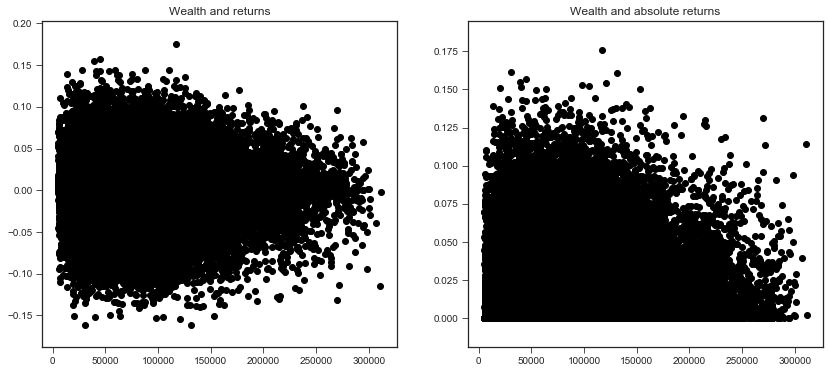

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax1.scatter(wealth_returns['wealth'], wealth_returns['returns'], color='k')
ax1.set_title('Wealth and returns')

ax2.scatter(wealth_returns['wealth'], wealth_returns['returns'].abs(), color='k')
ax2.set_title('Wealth and absolute returns')

**Pearson correlation**

In [9]:
np.corrcoef(wealth_returns['wealth'], wealth_returns['returns'])

array([[ 1.        , -0.01466973],
       [-0.01466973,  1.        ]])

In [10]:
np.corrcoef(wealth_returns['wealth'], wealth_returns['returns'].abs())

array([[ 1.        , -0.00200393],
       [-0.00200393,  1.        ]])

**Spearman rank correlation**

In [11]:
scipy.stats.spearmanr(wealth_returns['wealth'], wealth_returns['returns'])

SpearmanrResult(correlation=-0.004693968913077608, pvalue=0.2506357073306463)

In [12]:
scipy.stats.spearmanr(wealth_returns['wealth'], wealth_returns['returns'].abs())

SpearmanrResult(correlation=0.01965904785947066, pvalue=1.495668101491251e-06)

## 2 Do log returns correlate with log wealth?

Text(0.5, 1.0, 'Log wealth and absolute returns')

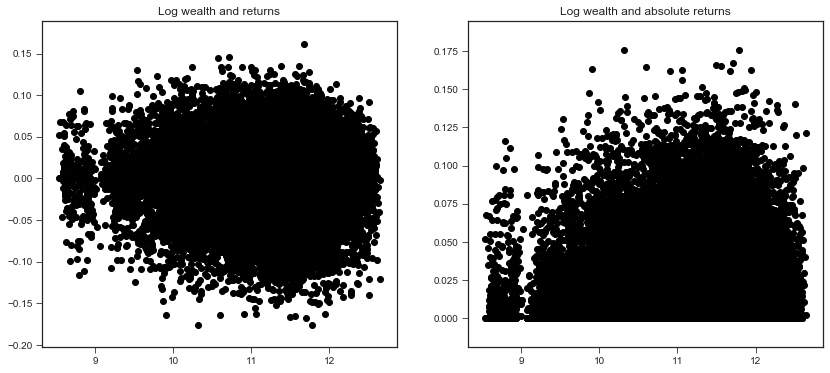

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax1.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'], color='k')
ax1.set_title('Log wealth and returns')

ax2.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs(), color='k')
ax2.set_title('Log wealth and absolute returns')

**Pearson correlation**

Log returns

In [14]:
np.corrcoef(wealth_returns['log_wealth'], wealth_returns['log_returns'])

array([[ 1.       , -0.0115599],
       [-0.0115599,  1.       ]])

Absolute log returns

In [15]:
np.corrcoef(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs())

array([[ 1.        , -0.00184765],
       [-0.00184765,  1.        ]])

**Spearman correlation**

In [16]:
scipy.stats.spearmanr(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs())

SpearmanrResult(correlation=0.019752793935426588, pvalue=1.3330390354035657e-06)

Text(0.5, 1.0, 'Y = log wealth and X = absolute returns')

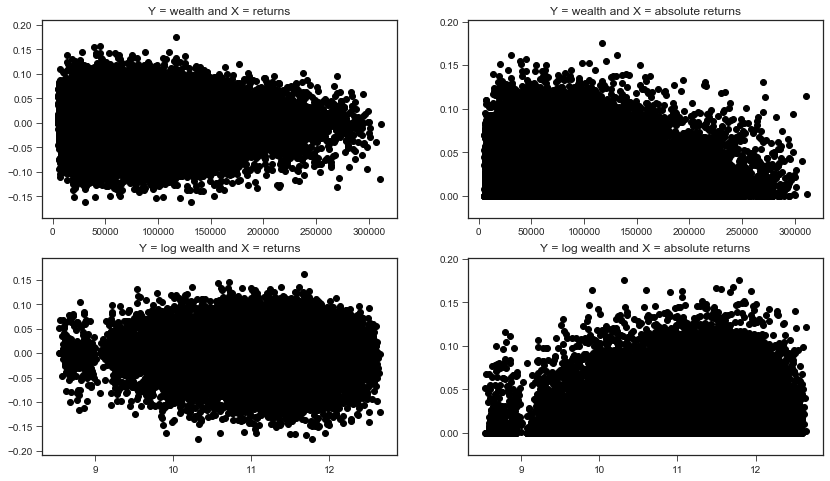

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

ax1.scatter(wealth_returns['wealth'], wealth_returns['returns'], color='k')
ax1.set_title('Y = wealth and X = returns')

ax2.scatter(wealth_returns['wealth'], wealth_returns['returns'].abs(), color='k')
ax2.set_title('Y = wealth and X = absolute returns')

ax3.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'], color='k')
ax3.set_title('Y = log wealth and X = returns')

ax4.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs(), color='k')
ax4.set_title('Y = log wealth and X = absolute returns')

#fig.savefig('wealth_return_scatter.png')

# Track the path of succesful traders:

In [18]:
# find the richest trader at the end of the simulation
best_trader = wealth_returns[wealth_returns['period'] == params['ticks']-2].sort_values(by=['wealth'], ascending=False).iloc[0].loc['agent_id']

In [19]:
best_traders = list(wealth_returns[wealth_returns['period'] == params['ticks']-2].sort_values(by=['wealth'], ascending=False).iloc[0:10]['agent_id'])

In [20]:
worst_traders = list(wealth_returns[wealth_returns['period'] == params['ticks']-2].sort_values(by=['wealth'], ascending=True).iloc[0:10]['agent_id'])

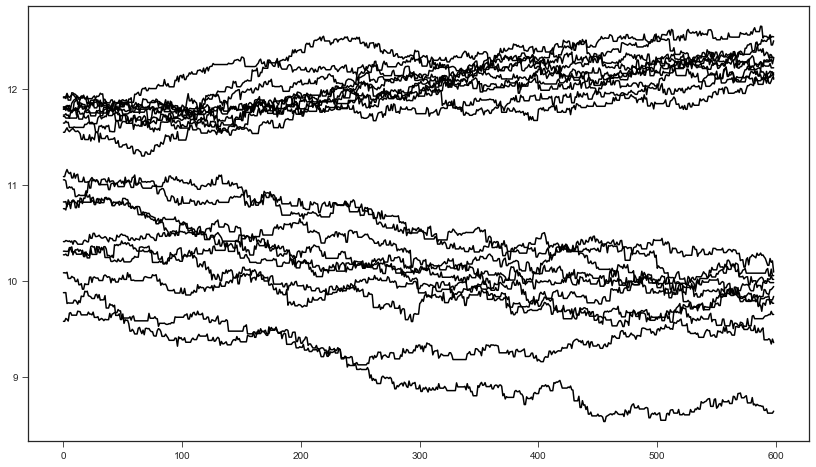

In [21]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14,8))

for tr in best_traders + worst_traders:
    ax1.plot(wealth_returns[wealth_returns['agent_id'] == tr]['period'], wealth_returns[wealth_returns['agent_id'] == tr]['log_wealth'], 'k')

### are the returns of the highest trader, on average higher... or more more stable? 

In [22]:
wealth_returns[wealth_returns['agent_id'] == best_trader]['log_returns'].std()

0.029375633753108848

In [23]:
wealth_returns[(wealth_returns['agent_id'] == tr) & (wealth_returns['period'] == 4998)]

,wealth,log_wealth,returns,log_returns,period,agent_id


In [24]:
final_wealth = []
stdev_returns = []
mean_returns = []
var_returns = []

for tr in wealth_returns['agent_id'].unique():
    final_wealth.append(wealth_returns[(wealth_returns['agent_id'] == tr) & (wealth_returns['period'] == params['ticks']-2)]['log_wealth'].iloc[0])
    stdev_returns.append(wealth_returns[(wealth_returns['agent_id'] == tr)]['log_returns'].std())
    var_returns.append(wealth_returns[(wealth_returns['agent_id'] == tr)]['log_returns'].var())
    mean_returns.append(wealth_returns[(wealth_returns['agent_id'] == tr)]['log_returns'].mean())

Text(0.5, 0, 'final wealth')

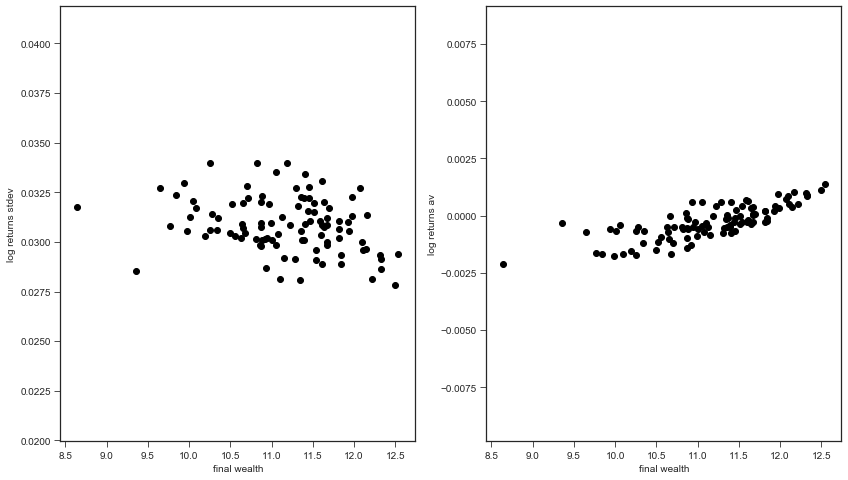

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,8))

ax1.scatter(final_wealth, stdev_returns, color='k')
ax1.set_ylabel('log returns stdev')
ax1.set_xlabel('final wealth')

ax2.scatter(final_wealth, mean_returns, color='k')
ax2.set_ylabel('log returns av')
ax2.set_xlabel('final wealth')

# ax3.scatter(final_wealth, var_returns, color='k')
# ax3.set_ylabel('log returns var')
# ax3.set_xlabel('final wealth')


## Model dynamics

In [26]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume = organise_data(orbs, burn_in_period=0)

In [27]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_prices)):
    price_range = mc_prices.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(max(lower, 0.0))
    upper_c_price.append(upper)

c:\users\joeri\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1920: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
c:\users\joeri\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1921: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


In [28]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
returns = []
absolute_returns = []
market_returns = []

returns_ot = []
wealth_ot = []
log_returns_ot = []
log_wealth_ot = []

# determine the start and end wealth
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # returns
    returns.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    absolute_returns.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    wealth_gini_over_time = []
    palma_over_time = []
    
    wealth_over_time = []
    returns_over_time = []
    log_returns_over_time = []
    log_wealth_over_time = []
    for t in range(params["ticks"]):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        wealth_gini_over_time.append(gini(wealth))
        
        for a in range(len(traders)):
            wealth_over_time.append(wealth[a])
            log_wealth_over_time.append(np.log(wealth[a]))

            if t > 0:
                returns_over_time.append((wealth_over_time[t] - wealth_over_time[t-1]) / wealth_over_time[-1])
                log_returns_over_time.append(np.log(wealth_over_time[t] / wealth_over_time[t-1])) # log returns = log(return + 1)

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    
    returns_ot.append(returns_over_time)
    wealth_ot.append(wealth_over_time)
    log_returns_ot.append(log_returns_over_time)
    log_wealth_ot.append(log_wealth_over_time)

In [29]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

for t in range(params["ticks"]):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)

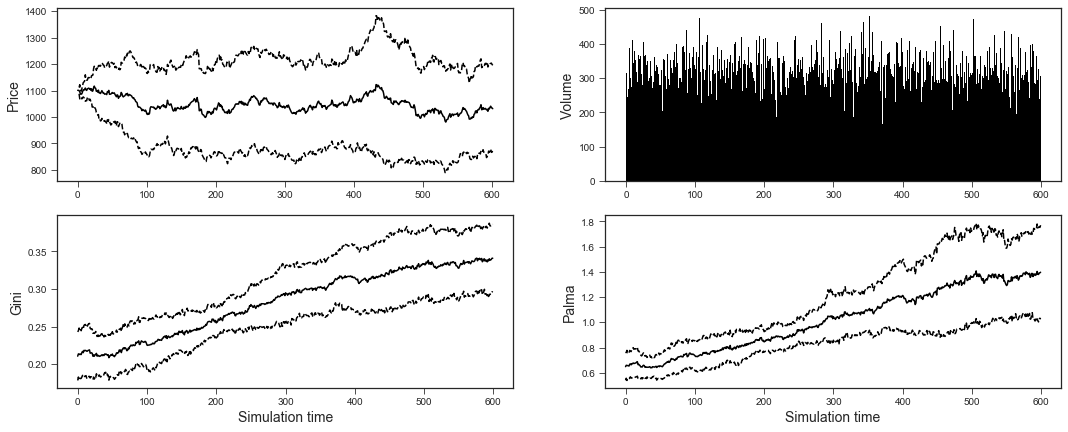

In [30]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(18,7))

ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k', label='Market')
ax1.plot(mc_prices.index[:], lower_c_price, 'k--')
ax1.plot(mc_prices.index[:], upper_c_price, 'k--')
ax1.set_ylabel('Price', fontsize='14')

ax2.bar(mc_volume.index, mc_volume.mean(axis=1), width=1.0, color='black')
ax2.set_ylabel('Volume', fontsize='14')

ax3.plot(range(len(av_gini_ot[:])), av_gini_ot[:], 'k')
ax3.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax3.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax3.set_ylabel('Gini', fontsize='14')

ax4.plot(range(len(av_gini_ot[:])), av_palma_ot[:], 'k')
ax4.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax4.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax4.set_ylabel('Palma', fontsize='14')


for ax in (ax3, ax4):
    ax.set_xlabel('Simulation time', fontsize='14')
    
#print(mc_prices.mean().mean())
#fig.savefig('uct_baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Returns and variance per quantile

For every period: divide the agents up in 5 quintiles by wealth  measure in every quantitative  average simple return, simple return variance, average log return, log return variance.

In [31]:
wealth_bin_labels = ['Very_Poor', 'Poor', 'Normal', 'Rich', 'Very_Rich']
wealth_returns['log_wealth_quantile'] = pd.qcut(wealth_returns['log_wealth'],
                                               q=[0, .2, .4, .6, .8, 1],
                                               labels=wealth_bin_labels)
wealth_returns['wealth_quantile'] = pd.qcut(wealth_returns['wealth'],
                                               q=[0, .2, .4, .6, .8, 1],
                                               labels=wealth_bin_labels)

In [143]:
wealth_returns.head(2)

,wealth,log_wealth,returns,log_returns,period,agent_id,log_wealth_quantile,wealth_quantile,time_quantile
0,625732.711325,13.346679,0.000000,0.000000,0,0,Very_Rich,Very_Rich,First
1,625732.711325,13.346679,-0.000783,-0.000783,1,0,Very_Rich,Very_Rich,First


In [130]:
#pd.qcut(wealth_returns['log_wealth'], q=[0, .2, .4, .6, .8, 1]).unique()

Then, for each quantile report on the average log return

In [131]:
labels = ['return_average', 'return_variance', 'log_return_average', 'log_return_variance']
quantile_stats = {'Very_Poor': [], 'Poor':[], 'Normal':[], 'Rich':[], 'Very_Rich': []}
for q in wealth_bin_labels:
    quantile_stats[q].append(wealth_returns[wealth_returns['log_wealth_quantile'] == q]['log_returns'].mean())
    quantile_stats[q].append(wealth_returns[wealth_returns['log_wealth_quantile'] == q]['log_returns'].var())
    quantile_stats[q].append(wealth_returns[wealth_returns['wealth_quantile'] == q]['returns'].mean())
    quantile_stats[q].append(wealth_returns[wealth_returns['wealth_quantile'] == q]['returns'].var())

In [132]:
q_stats = pd.DataFrame(quantile_stats, index=labels).transpose()

In [133]:
q_stats

,return_average,return_variance,log_return_average,log_return_variance
Very_Poor,-0.000362,0.000448,-0.000137,0.000449
Poor,-0.000623,0.000445,-0.000401,0.000444
Normal,-0.000358,0.000422,-0.000147,0.000420
Rich,-0.000468,0.000401,-0.000268,0.000398
Very_Rich,-0.000305,0.000376,-0.000118,0.000373


### Log and return averages

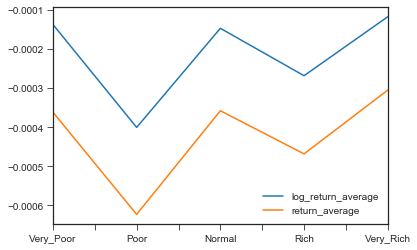

In [134]:
q_stats[['log_return_average', 'return_average']].plot()

### Wedge between returns & log returns
Is decreasing.

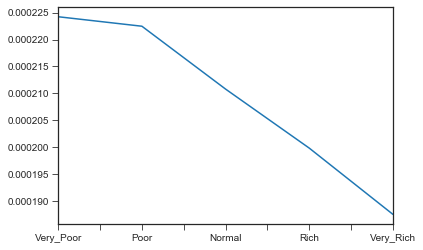

In [135]:
(q_stats['log_return_average'] - q_stats['return_average']).plot()

# Next, how do log returns evolve over time
Divide the simulation into time quantiles first. Then, for the rich / very rich, plot what happens to log returns over time. 

In [140]:
time_bin_labels = ['First', 'Second', 'Third', 'Fourth']
wealth_returns['time_quantile'] = pd.qcut(wealth_returns['period'],
                                               q=[0, .25, .5, .75, 1],
                                               labels=time_bin_labels)

In [144]:
wealth_returns.head(2)

,wealth,log_wealth,returns,log_returns,period,agent_id,log_wealth_quantile,wealth_quantile,time_quantile
0,625732.711325,13.346679,0.000000,0.000000,0,0,Very_Rich,Very_Rich,First
1,625732.711325,13.346679,-0.000783,-0.000783,1,0,Very_Rich,Very_Rich,First


Next, for the very rich, we observe log returns over time.

In [ ]:
wealth_ = wealth_returns[wealth_returns['log_wealth_quantile'] == ; 'Rich']

In [ ]:
labels = ['return_average', 'return_variance', 'log_return_average', 'log_return_variance']
quantile_stats = {'Very_Poor': [], 'Poor':[], 'Normal':[], 'Rich':[], 'Very_Rich': []}
for q in wealth_bin_labels:
    quantile_stats[q].append(wealth_returns[wealth_returns['log_wealth_quantile'] == q]['log_returns'].mean())
    quantile_stats[q].append(wealth_returns[wealth_returns['log_wealth_quantile'] == q]['log_returns'].var())
    quantile_stats[q].append(wealth_returns[wealth_returns['wealth_quantile'] == q]['returns'].mean())
    quantile_stats[q].append(wealth_returns[wealth_returns['wealth_quantile'] == q]['returns'].var())

# Experiment

In [73]:
stdev_fun = [x / 100.0 for x in range(0, 100, 1)]
stdev_fun = stdev_fun[1:10]

In [74]:
NRUNS = 3

In [75]:
stdev_fun 

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

In [76]:
experiments = len(stdev_fun)

In [77]:
trdrs = []
orbs = []

for exp in range(experiments):
    params['white_noise'] = stdev_fun[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects.init_objects_model(params, seed)
        traders, orderbook = volatility_inequality_model(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2


In [78]:
full_stdev = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_stdev.append(stdev_fun[exp])

In [79]:
ginis = []
palmas = []
var_log_returns = []

for idx, traders in enumerate(trdrs):
    wealth_end = np.array([x.var.wealth[-1] for x in trdrs[idx]])
    wealth_start = np.array([x.var.wealth[0] for x in trdrs[idx]])

    share_top_10 = sum(np.sort(wealth_end)[int(len(wealth_end) * 0.9):]) / sum(wealth_end)
    share_bottom_40 = sum(np.sort(wealth_end)[:int(len(wealth_end) * 0.4)]) / sum(wealth_end)
    palmas.append(share_top_10 / share_bottom_40)
    
    ginis.append(gini(wealth_end))
    var_log_returns.append(np.std(np.log(np.array(wealth_end) / np.array(wealth_start))))

In [80]:
# collect data on volatility
mc_prices_exp, mc_returns_exp, mc_autocorr_returns_exp, mc_autocorr_abs_returns_exp, mc_volatility_exp, mc_volume_exp = organise_data(orbs, burn_in_period=0)

In [110]:
av_stdev_prices_exp = list(mc_prices_exp.std(axis=0))
av_stdev_returns_exp = list(mc_returns_exp.std(axis=0))

In [82]:
# split the data in parts of NRUNS
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

pr_averages = []
pr_conf_interval_uppers = []
pr_conf_intervals_lowers = []

vol_averages = []
vol_conf_interval_uppers = []
vol_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    
    g = ginis[y:y+NRUNS]
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = palmas[y:y+NRUNS]
    palma_averages.append(np.mean(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))
    
    pr = var_log_returns[y:y+NRUNS]
    pr_averages.append(np.mean(pr))
    sample_stdev = np.std(pr)
    sigma = sample_stdev/math.sqrt(len(pr))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pr), scale = sigma) 
    pr_conf_interval_uppers.append(upper)
    pr_conf_intervals_lowers.append(max(lower, 0))
    
    v = av_stdev_prices_exp[y:y+NRUNS]
    vol_averages.append(np.mean(v))
    sample_stdev = np.std(v)
    sigma = sample_stdev/math.sqrt(len(v))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(v), scale = sigma) 
    vol_conf_interval_uppers.append(upper)
    vol_conf_intervals_lowers.append(max(lower, 0))

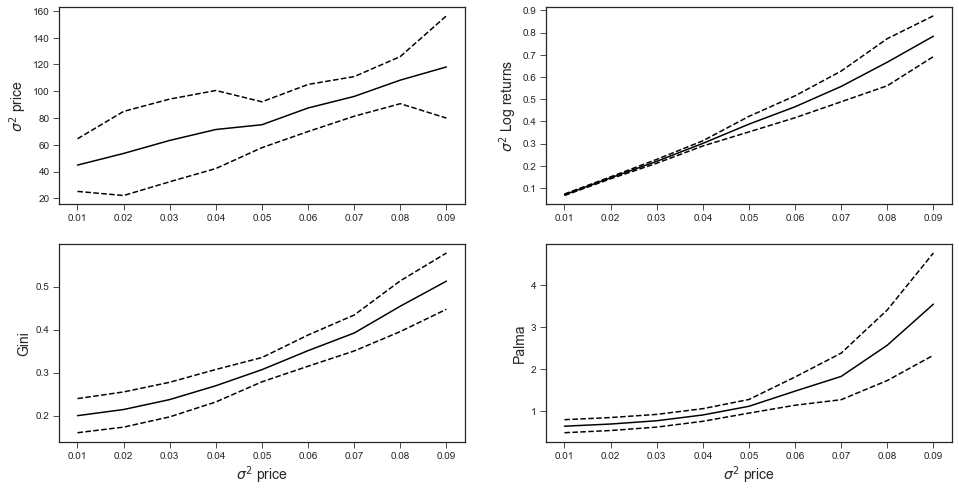

In [84]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[16,8])

ax1.plot(stdev_fun, vol_averages, 'k')
ax1.plot(stdev_fun, vol_conf_interval_uppers, 'k--')
ax1.plot(stdev_fun, vol_conf_intervals_lowers, 'k--')

ax2.plot(stdev_fun, pr_averages, 'k')
ax2.plot(stdev_fun, pr_conf_interval_uppers, 'k--')
ax2.plot(stdev_fun, pr_conf_intervals_lowers, 'k--')

ax3.plot(stdev_fun, gini_averages, 'k')
ax3.plot(stdev_fun, gini_conf_interval_uppers, 'k--')
ax3.plot(stdev_fun, gini_conf_intervals_lowers, 'k--')

ax4.plot(stdev_fun, palma_averages, 'k')
ax4.plot(stdev_fun, palma_conf_interval_uppers, 'k--')
ax4.plot(stdev_fun, palma_conf_intervals_lowers, 'k--')


ax1.set_ylabel('$\sigma^2$ price', fontsize=14)
ax2.set_ylabel('$\sigma^2$ Log returns', fontsize=14)
ax3.set_ylabel('Gini', fontsize=14)
ax4.set_ylabel('Palma', fontsize=14)


for ax in [ax3, ax4]:
    ax.set_xlabel('$\sigma^2$ price', fontsize=14)

fig.savefig('vol_logrets_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Regression

$\Delta Gini = \alpha + \beta \Delta volatility.$

$\Delta Palma = \alpha + \beta \Delta volatility.$

$\Delta Gini = \alpha + \beta \Delta parameter.$

$\Delta Palma = \alpha + \beta \Delta parameter.$

In [114]:
df = pd.DataFrame({'std_exp': full_stdev, 'ginis': ginis, 'stdev_returns': av_stdev_returns_exp,
              'palmas': palmas})
df['const'] = 1

In [119]:
gini_res_stdev = sm.OLS(endog=df['ginis'], exog=df[['const', 'stdev_returns']], missing='drop').fit()
palma_res_stdev = sm.OLS(endog=df['palmas'], exog=df[['const', 'stdev_returns']], missing='drop').fit()

In [117]:
gini_res = sm.OLS(endog=df['ginis'], exog=df[['const', 'std_exp']], missing='drop').fit()
palma_res = sm.OLS(endog=df['palmas'], exog=df[['const', 'std_exp']], missing='drop').fit()

In [118]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma'],
                            info_dict=info_dict,
                            regressor_order=['const', 'std_exp'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

               Table - OLS Regressions
                        Gini              Palma       
------------------------------------------------------
const            0.1292***          -0.1660           
                 (0.0182)           (0.2595)          
std_exp          3.9408***          33.3729***        
                 (0.3239)           (4.6109)          
R-squared        0.8555265938091574 0.6769404763374172
No. observations 27                 27                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [120]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res_stdev, palma_res_stdev],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma'],
                            info_dict=info_dict,
                            regressor_order=['const', 'stdev_returns'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

               Table - OLS Regressions
                        Gini              Palma       
------------------------------------------------------
const            0.1441***          -0.0993           
                 (0.0127)           (0.1953)          
stdev_returns    13.5206***         118.8931***       
                 (0.8142)           (12.5465)         
R-squared        0.9168863373027168 0.7822254935587545
No. observations 27                 27                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [122]:
pd.DataFrame({'agent_1_seed_1':[1, 2, 3], 'agent_2_seed_2':[4,5,6]})

,agent_1_seed_1,agent_2_seed_2
0,1,4
1,2,5
2,3,6


In [113]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
returns = []
absolute_returns = []
market_returns = []

returns_ot = []
wealth_ot = []
log_returns_ot = []
log_wealth_ot = []

# determine the start and end wealth
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # returns
    returns.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    absolute_returns.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    wealth_gini_over_time = []
    palma_over_time = []
    
    wealth_over_time = []
    returns_over_time = []
    log_returns_over_time = []
    log_wealth_over_time = []
    for t in range(params["ticks"]):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        wealth_gini_over_time.append(gini(wealth))
        
        for a in range(len(traders)):
            wealth_over_time.append(wealth[a])
            log_wealth_over_time.append(np.log(wealth[a]))

            if t > 0:
                returns_over_time.append((wealth_over_time[t] - wealth_over_time[t-1]) / wealth_over_time[-1])
                log_returns_over_time.append(np.log(wealth_over_time[t] / wealth_over_time[t-1])) # log returns = log(return + 1)

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    
    returns_ot.append(returns_over_time)
    wealth_ot.append(wealth_over_time)
    log_returns_ot.append(log_returns_over_time)
    log_wealth_ot.append(log_wealth_over_time)

### Do log returns correlate with log wealth?

I need a df of all returns next to log returns next to wealth of the previous period, next to log wealth 

In [114]:
len(returns_ot[0])

49900

In [115]:
returns_and_wealth = pd.DataFrame([wealth_ot[0], log_wealth_ot[0], returns_ot[0], log_returns_ot[0]]).transpose().loc[499:49499].dropna()

In [116]:
returns_and_wealth.columns = ['wealth_t', 'log_wealth_t', 'return_t+1', 'log_returns_t+1']

In [117]:
returns_and_wealth[['wealth_t', 'log_wealth_t']].corrwith(returns_and_wealth[['return_t+1', 'log_returns_t+1']], axis=0)

log_returns_t+1   NaN
log_wealth_t      NaN
return_t+1        NaN
wealth_t          NaN
dtype: float64

In [110]:
#returns_and_wealth[['wealth_t', 'return_t+1']]

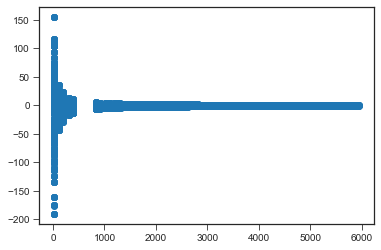

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(returns_and_wealth['wealth_t'], returns_and_wealth['return_t+1'])

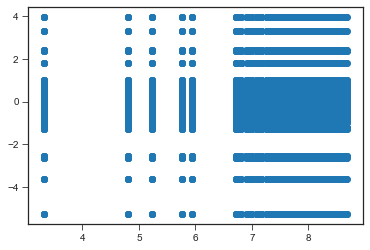

In [119]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(returns_and_wealth['log_wealth_t'], returns_and_wealth['log_returns_t+1'])